In [1]:
## first of all importing the secret variables
import os
from dotenv import load_dotenv
load_dotenv() ##

api_key = os.getenv("OPENAI_API_KEY")

In [2]:
serper_api_key = os.getenv("SERPER_API_KEY")

In [45]:
from langchain.tools import Tool
from langchain.utilities import SerpAPIWrapper
search = SerpAPIWrapper(serpapi_api_key=serper_api_key)

In [46]:
search.run("who is pm of India?") ## serper api is working fine

"['Narendra Modi type: Prime Minister of India.', 'Narendra Modi kgmid: /m/0296q2.', 'Narendra Modi born: September 17, 1950 (age 74 years), Vadnagar, India.', 'Narendra Modi parents: Heeraben Modi, Damodardas Mulchand Modi.', 'Narendra Modi spouse: Jashodaben Modi (m. 1968).', 'The prime minister is appointed by the president of India; however, the prime minister has to enjoy the confidence of the majority of Lok Sabha members, who are ...', 'After the 2024 Indian general election, Modi became the prime minister for the third consecutive time, leading a coalition government after the BJP lost its ...', 'The Prime Minister, Shri Narendra Modi applauded Reserve Bank of India (RBI) for Winning Digital Transformation Award 2025.', 'Shri Atal Bihari Vajpayee served as Prime Minister of India for 13 days in 1996 and two incomplete terms from 1998 to 2004. He is known for his valuable ...', 'Currently, Narendra Modi is the Prime Minister of India, having been in office since 2014. He is the 

In [6]:
## ignoring the warnings
import warnings
warnings.filterwarnings('ignore')

In [8]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model = "gpt-3.5-turbo",api_key=api_key)
from langchain_huggingface import HuggingFaceEmbeddings
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

In [10]:
llm.invoke("what is machine learning?").content

'Machine learning is a subset of artificial intelligence that focuses on developing algorithms and models that allow computers to learn from data and make predictions or decisions without being explicitly programmed. The goal of machine learning is to enable computers to learn and improve their performance on a given task over time, by making use of patterns and information within the data they are provided. Machine learning algorithms can be broadly classified into supervised learning, unsupervised learning, and reinforcement learning, each of which is used for different types of tasks and problems. Machine learning is increasingly being used in a wide range of applications, including image and speech recognition, healthcare, finance, and autonomous vehicles.'

In [11]:
from langchain_text_splitters import RecursiveCharacterTextSplitter ## for splitting the text into chunks
from langchain_community.document_loaders import TextLoader ## for loading the text from website
from langchain_community.vectorstores import Chroma


In [12]:
text = TextLoader("rocketchat_qna.txt")
docs = text.load()
docs

[Document(metadata={'source': 'rocketchat_qna.txt'}, page_content="Question: How can I extend the functionality of my Rocket.Chat workspace?\nAnswer: To enhance your workspace's capabilities, you have several options:\n\n- **Submit a Pull Request:** Modify the source code directly to implement new features. This approach offers maximum flexibility but requires familiarity with the codebase.\n\n- **Use Integrations:** Create simple scripts that execute when messages are sent or received in a channel. Integrations are quick to develop but have limited scope.\n\n- **Build a Rocket.Chat App:** Develop apps that interact with the user interface and execute custom routines on various triggers. This method provides a balance between power and complexity and allows for distribution via the Rocket.Chat Marketplace.\n\nEach method has its strengths and can be chosen based on your specific requirements and technical expertise.\nSource: https://docs.rocket.chat/docs/rocketchat-apps-faq?utm_source=

In [13]:
## splitting the text data
from langchain_text_splitters import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size = 200,chunk_overlap = 100
)
docs_split = text_splitter.split_documents(docs)

In [17]:
## i have splitted my text data now i  will convert this text data into word vector embeddings
## and will store that word vector embeddings into the vector database
vectorstore = Chroma.from_documents(
    documents=docs_split,
    embedding=embeddings,
    collection_name="rag-chroma"
)
## creating retriever on top of this retriever
retriever = vectorstore.as_retriever()

In [ ]:
## i successfully created the retriever 
## now i will be creating the reranker on top of this retriever

In [15]:
retriever.invoke("How can I extend the functionality of my Rocket.Chat workspace?")

[Document(metadata={'source': 'rocketchat_qna.txt'}, page_content="Question: How can I extend the functionality of my Rocket.Chat workspace?\nAnswer: To enhance your workspace's capabilities, you have several options:\n\n- **Submit a Pull Request:** Modify the source code directly to implement new features. This approach offers maximum flexibility but requires familiarity with the codebase.\n\n- **Use Integrations:** Create simple scripts that execute when messages are sent or received in a channel. Integrations are quick to develop but have limited scope.\n\n- **Build a Rocket.Chat App:** Develop apps that interact with the user interface and execute custom routines on various triggers. This method provides a balance between power and complexity and allows for distribution via the Rocket.Chat Marketplace."),
 Document(metadata={'source': 'rocketchat_qna.txt'}, page_content="Each method has its strengths and can be chosen based on your specific requirements and technical expertise.\nSo

In [18]:

from langchain.document_transformers import (
    EmbeddingsClusteringFilter,
    EmbeddingsRedundantFilter,
)
from langchain.retrievers.document_compressors import DocumentCompressorPipeline
from langchain.retrievers import ContextualCompressionRetriever
from langchain.document_transformers import LongContextReorder

In [21]:


from re import search
filter = EmbeddingsRedundantFilter(embeddings=embeddings)
reordering = LongContextReorder()
pipeline = DocumentCompressorPipeline(transformers=[filter, reordering])
compression_retriever_reordered = ContextualCompressionRetriever(
    base_compressor=pipeline, base_retriever=retriever,search_kwargs={"k": 3,"include_metadata":True}
)

In [ ]:
compression_retriever_reordered .invoke("How can I extend the functionality of my Rocket.Chat workspace?") ## now i will be using this in place of simple retriever

[_DocumentWithState(metadata={'source': 'rocketchat_qna.txt'}, page_content="Each method has its strengths and can be chosen based on your specific requirements and technical expertise.\nSource: https://docs.rocket.chat/docs/rocketchat-apps-faq?utm_source=chatgpt.com\nCategory: Development\n--------------------------------------------------\nQuestion: How do I access my Rocket.Chat workspace if I've forgotten its URL?\nAnswer: If you've forgotten your workspace URL, it's recommended to contact your workspace administrator or IT department. They can provide you with the correct URL to access your Rocket.Chat environment.\nSource: https://docs.rocket.chat/docs/workspace-faq\nCategory: Access & Login\n--------------------------------------------------\nQuestion: How do I deploy Rocket.Chat with AWS for Apple Silicon Macs (M-series)\nAnswer: During EC2 instance launch, choose a different operating system, such as Ubuntu, from the 'Application and OS Images' (Amazon Machine Image) section."

In [23]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel,Field

In [24]:
class GradeDocuments(BaseModel):
    "Relevance score 'yes' or 'no'" 
    binary_score:str = Field(
        description = "Documents are relevant to the question 'yes' or 'no'"
    )

In [25]:
llm_with_structured_output = llm.with_structured_output(GradeDocuments)
system = """ You are a document grader.Given the question and documents given to you.
your job is to find out either these documents are relevant to question or not.
if the question is relevant to documents return binary_score = 'yes' 
and if the question is not relevant to documents then return binary_score = 'no'
                                """  
prompt = ChatPromptTemplate.from_messages(
[
    ("system",system),
    ("human","documents:{documents} \n question:{question}")
]
)
document_grader = prompt | llm_with_structured_output

In [26]:
## now creating the rag pipeline
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
prompt = hub.pull("rlm/rag-prompt")
rag_chain = prompt | llm | StrOutputParser()

In [27]:
system = """  You are a question rewriter. You will be given a question. Your job is to understand the context of the question carefully
and update the question so that we can extract maximum information with the help of this question.Do not add any extra thing to question.
if you are not able to do some addition on it .let the question as it as.
              
               """
prompt = ChatPromptTemplate.from_messages(
    [
        ("system",system),
        ("human","question:{question}")
    ]
)

question_rewriter = prompt | llm | StrOutputParser()

In [28]:
question_rewriter.invoke("what is machine learning?")

'What are the key concepts and applications of machine learning?'

In [29]:
## now creating all the functions for the graph which will act as the nodes inside the graph
def retrieve(state):
    "This function will retrieve the relevant documents from the vector database based on the user question"
    question = state["question"] 
    documents = compression_retriever_reordered .invoke(question)

    return {"question":question,"documents":documents}

In [30]:
def grade_documents(state):
    "This function will grade documents based on the question"
    question = state["question"] ## user question
    documents = state["documents"] ## documents fetched form the vector datavbase

    filtered_docs = []
    web_search = "no"

    for d in docs:
        score = document_grader.invoke({"question":question,"documents":d})
        binary_score = score.binary_score
        if binary_score == "yes":
            filtered_docs.append(d)
        else:
            web_search = "yes"
    return {"question":question,"documents":filtered_docs,"web_search":web_search}

In [31]:
def generate(state):
    "This function will generate response based on the question and the retrieved documents, this will be used if web_search == 'no' "
    question = state["question"]
    documents = state["documents"]

    generated_response = rag_chain.invoke({"question":question,"context":documents})

    return {"question":question,"documents":documents,"response":generated_response}

In [32]:
## writting query rewritter function
def transform_query(state):
    "This function will rewrite the query, so that this query may able to fetch maximum information from the web search"
    question = state["question"]
    documents = state["documents"]

    new_question = question_rewriter.invoke({"question":question})
    return {"question":new_question,"documents":documents}

In [33]:
from langchain.schema import Document

In [34]:

def net_search(state):
    question = state["question"]
    documents = state["documents"]
    response = search.run(question)
    document = Document(page_content=response)
    documents.append(document)
    return {"question":question,"documents":documents}

In [35]:
def decide_to_generate(state):
    "this function takes the decision either to generate or transform the query"
    question = state["question"]
    documents = state["documents"]
    web_search = state["web_search"]

    if web_search == "yes":
        return "transform_query"
    else:
        return "generate"

In [36]:
from langgraph.graph import StateGraph,START,END
from typing import List
from typing_extensions import TypedDict

In [37]:

class State(TypedDict):
    question:str
    documents:List[str]
    web_search:str
    response:str
    
workflow = StateGraph(State)

workflow.add_node("retrieve",retrieve)
workflow.add_node("document_grader",grade_documents)
workflow.add_node("generate",generate)
workflow.add_node("net_search",net_search)
workflow.add_node("transform_query",transform_query)
## created all the nodes now i will be creating all the edges
workflow.add_edge(START,"retrieve")
workflow.add_edge("retrieve","document_grader")
## now using conditional edge
workflow.add_conditional_edges("document_grader",decide_to_generate,{"transform_query":"transform_query","generate":"generate"})
workflow.add_edge("transform_query","net_search")
workflow.add_edge("net_search","generate")
workflow.add_edge("generate",END)

In [38]:
app = workflow.compile()

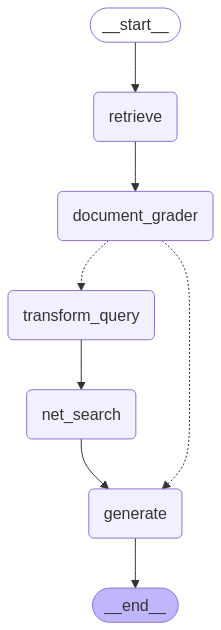

In [39]:

# Display the graph
from IPython.display import Image, display # type: ignore
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [40]:
question = "How can I extend the functionality of my Rocket.Chat workspace?"
inputs = {"question":question}
response = app.invoke(inputs)
response 

{'question': 'How can I extend the functionality of my Rocket.Chat workspace?',
 'documents': [Document(metadata={'source': 'rocketchat_qna.txt'}, page_content="Question: How can I extend the functionality of my Rocket.Chat workspace?\nAnswer: To enhance your workspace's capabilities, you have several options:\n\n- **Submit a Pull Request:** Modify the source code directly to implement new features. This approach offers maximum flexibility but requires familiarity with the codebase.\n\n- **Use Integrations:** Create simple scripts that execute when messages are sent or received in a channel. Integrations are quick to develop but have limited scope.\n\n- **Build a Rocket.Chat App:** Develop apps that interact with the user interface and execute custom routines on various triggers. This method provides a balance between power and complexity and allows for distribution via the Rocket.Chat Marketplace.\n\nEach method has its strengths and can be chosen based on your specific requirements a

In [41]:
question = "How do I access my Rocket.Chat workspace if I've forgotten its URL?"
inputs = {"question":question}
response = app.invoke(inputs)
response 

{'question': "How do I access my Rocket.Chat workspace if I've forgotten its URL?",
 'documents': [Document(metadata={'source': 'rocketchat_qna.txt'}, page_content="Question: How can I extend the functionality of my Rocket.Chat workspace?\nAnswer: To enhance your workspace's capabilities, you have several options:\n\n- **Submit a Pull Request:** Modify the source code directly to implement new features. This approach offers maximum flexibility but requires familiarity with the codebase.\n\n- **Use Integrations:** Create simple scripts that execute when messages are sent or received in a channel. Integrations are quick to develop but have limited scope.\n\n- **Build a Rocket.Chat App:** Develop apps that interact with the user interface and execute custom routines on various triggers. This method provides a balance between power and complexity and allows for distribution via the Rocket.Chat Marketplace.\n\nEach method has its strengths and can be chosen based on your specific requiremen

In [47]:
question = "who was first president of India?"
inputs = {"question":question}
response = app.invoke(inputs)
response 

{'question': 'Who was the inaugural president of India?',
 'documents': [Document(metadata={}, page_content='Rajendra Prasad (3 December 1884 – 28 February 1963) was an Indian politician, lawyer, journalist and scholar who served as the first president of India from 1950 to 1962. He joined the Indian National Congress during the Indian independence movement and became a major leader from the region of Bihar.')],
 'web_search': 'yes',
 'response': 'The inaugural president of India was Rajendra Prasad. He served as the first president from 1950 to 1962. Prasad was also a prominent Indian politician, lawyer, journalist, and scholar.'}